### Straw Donors Data

In [1]:
# Loading required libraries
%pylab inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
import seaborn as sns
sns.set(style="white", color_codes=True)

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


#### Individual Contributions

In [2]:
# Loading individual contributions data
individual = pd.read_csv("individual_contributions.csv")
print individual.shape
print individual.columns

(4869491, 14)
Index([u'Unnamed: 0', u'CORP', u'FIRST_NAME', u'LAST_NAME', u'ADDR', u'CITY',
       u'STATE', u'ZIP', u'RECIPIENT', u'FILER_ID', u'CHECK_NO', u'DATE1',
       u'AMOUNT', u'BOEE_ID'],
      dtype='object')


In [3]:
individual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4869491 entries, 0 to 4869490
Data columns (total 14 columns):
Unnamed: 0    int64
CORP          object
FIRST_NAME    object
LAST_NAME     object
ADDR          object
CITY          object
STATE         object
ZIP           object
RECIPIENT     object
FILER_ID      object
CHECK_NO      object
DATE1         object
AMOUNT        object
BOEE_ID       int64
dtypes: int64(2), object(12)
memory usage: 557.3+ MB


STATE
NY      3120073
NJ       195590
CT       158761
None     148765
TX       131847
CA       110825
OH       100427
IL        94383
PA        76917
FL        61315
dtype: int64


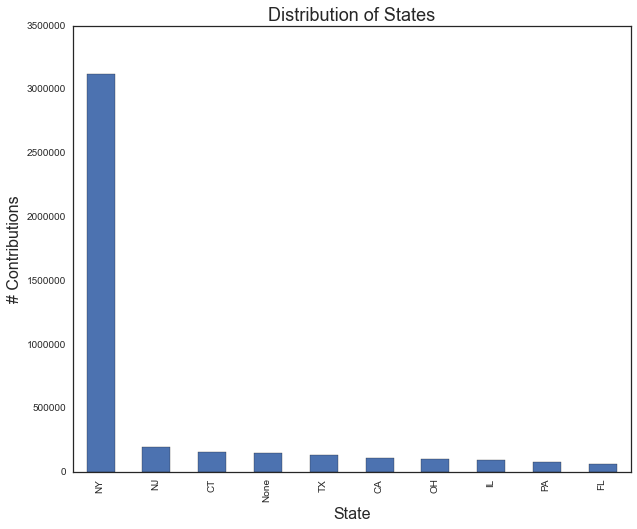

In [4]:
# Looking at distribution of indivudual contributions across states
print individual.groupby(['STATE']).size().order(ascending=False)[:10]
plt.figure(figsize=(10,8))
freqPlot = individual.groupby(['STATE']).size().order(ascending=False)[:10].plot(kind='bar')
freqPlot.set_title("Distribution of States", fontsize=18)
freqPlot.set_xlabel("State", fontsize=16)
freqPlot.set_ylabel("# Contributions", fontsize=16)

RECIPIENT
WORKING FAMILIES PARTY, INC.                                                        394609
J. P. MORGAN CHASE & CO. PAC                                                        322339
PFIZER INC PAC                                                                      240555
DEMOCRAT, REPUBLICAN, INDEPENDENT VOTER EDUCATION (D.R.I.V.E.)                      192504
CITIGROUP INC. POLITICAL ACTION COMMITTEE - FEDERAL/STATE (CITIGROUP PAC - FEDER    146509
THE HARTFORD FINANCIAL SERVICES GROUP, INC. PAC (AKA THE HARTFORD ADVOCATES FUND    126340
WELLPOINT, INC. WELLPAC                                                             122572
METLIFE INC. EMPLOYEES' POLITICAL PARTICIPATION FUND A                               94196
WYETH GOOD GOVERNMENT FUND                                                           89854
VOICE OF TEACHERS FOR EDUCATION / COMMITTEE ON POLITICAL EDUCATION OF THE NEW YO     75373
REALTORS POLITICAL ACTION COMMITTEE                                             

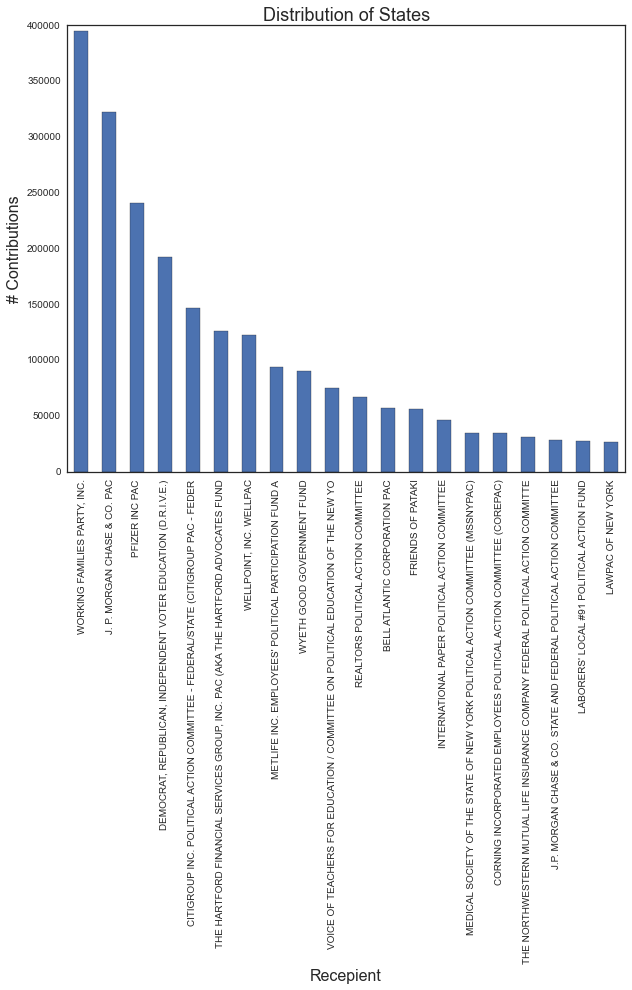

In [5]:
# Looking at distribution of indivudual contributions across states
print individual.groupby(['RECIPIENT']).size().order(ascending=False)[:20]
plt.figure(figsize=(10,8))
freqPlot = individual.groupby(['RECIPIENT']).size().order(ascending=False)[:20].plot(kind='bar')
freqPlot.set_title("Distribution of States", fontsize=18)
freqPlot.set_xlabel("Recepient", fontsize=16)
freqPlot.set_ylabel("# Contributions", fontsize=16)

#### Subset only for WORKING FAMILIES PARTY, INC.

In [23]:
recipient = ['WORKING FAMILIES PARTY, INC.']
individual_wfp = individual.loc[(individual.RECIPIENT.isin(recipient)),]
print individual_wfp.shape

(394609, 14)


In [24]:
# Finding discrepancies in DATE1 column
print individual_wfp['DATE1'].unique()
freqs = individual_wfp.groupby(['DATE1']).size()
print len(freqs)
lendate1 = []

for i in range(len(freqs.index)):
    lendate1.append(len(freqs.index[i]))

lendate1 = pd.Series(lendate1)
print len(lendate1)
print lendate1.unique()

['2002-07-25 12:07:00' '2002-08-22 12:08:00' '2002-09-24 12:09:00' ...,
 '2014-02-04 00:00:00' '2014-02-26 00:00:00' '2014-04-04 00:00:00']
3265
3265
[19]


In [25]:
# Finding discrepancies in FILER_ID column
print individual_wfp['FILER_ID'].unique()
freqs = individual_wfp.groupby(['FILER_ID']).size()
print len(freqs)
lenfilerid = []

for i in range(len(freqs.index)):
    lenfilerid.append(len(freqs.index[i]))

lenfilerid = pd.Series(lenfilerid)
print len(lenfilerid)
print lenfilerid.unique()

['A08215']
1
1
[6]


In [38]:
# Converting amount from string to float
import re
AMOUNT = list(individual_wfp['AMOUNT'])
print len(AMOUNT)
AMT = []
for i in range(len(AMOUNT)):
    AMT.append(int(float(re.sub(r'[?|$|!|,]',r'', AMOUNT[i]))))

print len(AMT)
individual_wfp.loc[:,'AMT'] = AMT

394609
394609


In [39]:
individual_wfp.head()

,Unnamed: 0,CORP,FIRST_NAME,LAST_NAME,ADDR,CITY,STATE,ZIP,RECIPIENT,FILER_ID,CHECK_NO,DATE1,AMOUNT,BOEE_ID,AMT
989405,1362998,None,WINIFRED,BENJAMIN,4100 HUTCHINSON RIVER PKWY E APT 7D,BRONX,NY,10475,"WORKING FAMILIES PARTY, INC.",A08215,BANK DEBI,2002-07-25 12:07:00,$10.00,2498442,10
989406,1362999,None,WINIFRED,BENJAMIN,4100 HUTCHINSON RIVER PKWY E APT 7D,BRONX,NY,10475,"WORKING FAMILIES PARTY, INC.",A08215,BANK DEBI,2002-08-22 12:08:00,$10.00,2498443,10
989407,1363000,None,WINIFRED,BENJAMIN,4100 HUTCHINSON RIVER PKWY E APT 7D,BRONX,NY,10475,"WORKING FAMILIES PARTY, INC.",A08215,BANK DEBI,2002-09-24 12:09:00,$10.00,2498444,10
989408,1363001,None,WINIFRED,FITZGERALD,340 BEACH 149TH ST,ROCKAWAY PARK,NY,11694,"WORKING FAMILIES PARTY, INC.",A08215,908,2002-07-22 12:07:00,$36.00,2498445,36
989409,1363002,None,WINIFRED,SHERIDAN,2036 COLEMAN ST,BROOKLYN,NY,11234,"WORKING FAMILIES PARTY, INC.",A08215,5010,2002-07-22 12:07:00,$5.00,2498446,5


In [40]:
individual_wfp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394609 entries, 989405 to 4772073
Data columns (total 15 columns):
Unnamed: 0    394609 non-null int64
CORP          394609 non-null object
FIRST_NAME    394609 non-null object
LAST_NAME     394609 non-null object
ADDR          394609 non-null object
CITY          394609 non-null object
STATE         394609 non-null object
ZIP           394609 non-null object
RECIPIENT     394609 non-null object
FILER_ID      394609 non-null object
CHECK_NO      394609 non-null object
DATE1         394609 non-null object
AMOUNT        394609 non-null object
BOEE_ID       394609 non-null int64
AMT           394609 non-null int64
dtypes: int64(3), object(12)
memory usage: 48.2+ MB


In [41]:
# Extracting year from DATE1 column
print individual_wfp['DATE1'][:10]

989405    2002-07-25 12:07:00
989406    2002-08-22 12:08:00
989407    2002-09-24 12:09:00
989408    2002-07-22 12:07:00
989409    2002-07-22 12:07:00
989410    2002-09-16 12:09:00
989411    2002-08-01 12:08:00
989412    2002-08-01 12:08:00
989413    2002-07-15 12:07:00
989414    2002-07-17 12:07:00
Name: DATE1, dtype: object


In [44]:
individual_wfp['YEAR'] = individual_wfp['DATE1'].str[:4]
print individual_wfp['YEAR'].unique()

['2002' '2001' '2000' '1999' '0200' '1900' '2003' '2008' '2007' '2006'
 '2009' '2010' '2011' '1901' '2004' '2005' '2012' '2013' '2014']


In [45]:
print individual_wfp.shape
years = ['2002','2001','2000','1999','2003','2008','2007','2006',
         '2009','2010','2011','2004','2005','2012','2013','2014']
individual_wfp = individual_wfp.loc[(individual_wfp.YEAR.isin(years)),]
print individual_wfp.shape

(394609, 16)
(394603, 16)


In [52]:
# Getting counts of state
individual_wfp.groupby('STATE').size().order(ascending=False)[:10]

STATE
NY      383008
None      4347
MA        2609
NJ        1229
CT         619
CA         500
MD         248
PA         232
NC         167
DC         132
dtype: int64

YEAR
1999      231
2000      646
2001     4969
2002    17214
2003    16401
2004    39502
2005    40076
2006    48219
2007    26582
2008    39985
2009    61215
2010    42657
2011    52573
2012     3177
2013      682
2014      474
dtype: int64


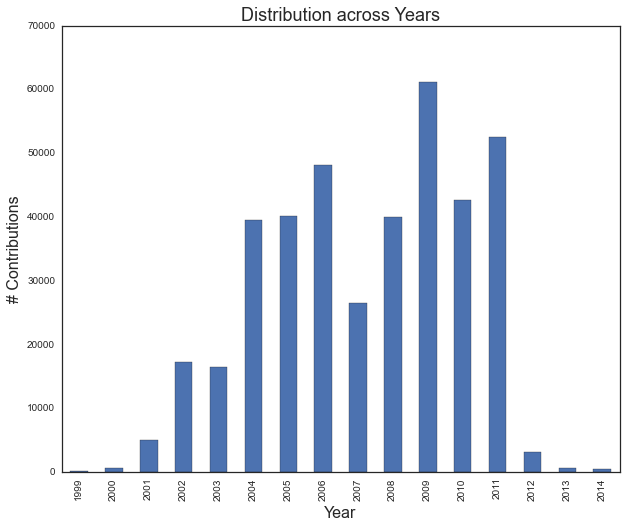

In [53]:
# Looking at distribution of indivudual contributions across states
print individual_wfp.groupby(['YEAR']).size().sort_index(ascending=True)
plt.figure(figsize=(10,8))
freqPlot = individual_wfp.groupby(['YEAR']).size().sort_index(ascending=True).plot(kind='bar')
freqPlot.set_title("Distribution across Years", fontsize=18)
freqPlot.set_xlabel("Year", fontsize=16)
freqPlot.set_ylabel("# Contributions", fontsize=16)

In [54]:
individual_wfp.columns

Index([u'Unnamed: 0', u'CORP', u'FIRST_NAME', u'LAST_NAME', u'ADDR', u'CITY',
       u'STATE', u'ZIP', u'RECIPIENT', u'FILER_ID', u'CHECK_NO', u'DATE1',
       u'AMOUNT', u'BOEE_ID', u'AMT', u'YEAR'],
      dtype='object')

In [57]:
individual_wfp_nodup = individual_wfp[['FIRST_NAME', 'LAST_NAME', 'ADDR']].drop_duplicates()
individual_wfp_nodup.shape

(227792, 3)

In [59]:
individual_wfp_nodup.head()

,FIRST_NAME,LAST_NAME,ADDR
989405,WINIFRED,BENJAMIN,4100 HUTCHINSON RIVER PKWY E APT 7D
989408,WINIFRED,FITZGERALD,340 BEACH 149TH ST
989409,WINIFRED,SHERIDAN,2036 COLEMAN ST
989410,WINSTON,HOWE,25735 148TH DR
989411,WINSTON,REID,582 BERGEN ST


In [60]:
individual_wfp_nodup.to_csv("individual_wfp_nodup.csv")

#### Subset for J. P. MORGAN CHASE & CO. PAC

In [61]:
recipient = ['J. P. MORGAN CHASE & CO. PAC']
individual_jpmc = individual.loc[(individual.RECIPIENT.isin(recipient)),]
print individual_jpmc.shape

(322339, 14)


In [63]:
# Converting amount from string to float
import re
AMOUNT = list(individual_jpmc['AMOUNT'])
print len(AMOUNT)
AMT = []
for i in range(len(AMOUNT)):
    AMT.append(int(float(re.sub(r'[?|$|!|,]',r'', AMOUNT[i]))))

print len(AMT)
individual_jpmc.loc[:,'AMT'] = AMT

322339
322339


In [64]:
individual_jpmc['YEAR'] = individual_jpmc['DATE1'].str[:4]
print individual_jpmc['YEAR'].unique()

['2007' '2008' '2009' '2010' '2011' '2006' '2005' '2012' '2013' '2014']


In [65]:
print individual_jpmc.shape
years = ['2002','2001','2000','1999','2003','2008','2007','2006',
         '2009','2010','2011','2004','2005','2012','2013','2014']
individual_jpmc = individual_jpmc.loc[(individual_jpmc.YEAR.isin(years)),]
print individual_jpmc.shape

(322339, 16)
(322339, 16)


In [66]:
# Getting counts of state
individual_jpmc.groupby('STATE').size().order(ascending=False)[:10]

STATE
NY    63136
OH    55843
TX    37709
IL    33828
NJ    19542
DE    19519
AZ    16585
IN     9351
FL     8250
MI     7771
dtype: int64

YEAR
2005    41342
2006    30007
2007    36106
2008    36115
2009    38087
2010    40787
2011    39385
2012    41360
2013    17009
2014     2141
dtype: int64


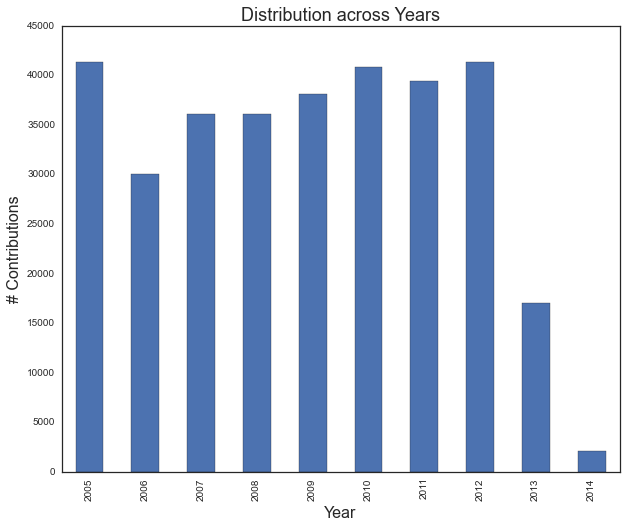

In [67]:
# Looking at distribution of indivudual contributions across states
print individual_jpmc.groupby(['YEAR']).size().sort_index(ascending=True)
plt.figure(figsize=(10,8))
freqPlot = individual_jpmc.groupby(['YEAR']).size().sort_index(ascending=True).plot(kind='bar')
freqPlot.set_title("Distribution across Years", fontsize=18)
freqPlot.set_xlabel("Year", fontsize=16)
freqPlot.set_ylabel("# Contributions", fontsize=16)

#### Plotting campaign contributions for state and year across top 20 recipients

In [75]:
recipients = list(individual.groupby(['RECIPIENT']).size().order(ascending=False)[:20].index)
type(recipients)

list

In [97]:
recipients

['WORKING FAMILIES PARTY, INC.',
 'J. P. MORGAN CHASE & CO. PAC',
 'PFIZER INC PAC',
 'DEMOCRAT, REPUBLICAN, INDEPENDENT VOTER EDUCATION (D.R.I.V.E.)',
 'CITIGROUP INC. POLITICAL ACTION COMMITTEE - FEDERAL/STATE (CITIGROUP PAC - FEDER',
 'THE HARTFORD FINANCIAL SERVICES GROUP, INC. PAC (AKA THE HARTFORD ADVOCATES FUND',
 'WELLPOINT, INC. WELLPAC',
 "METLIFE INC. EMPLOYEES' POLITICAL PARTICIPATION FUND A",
 'WYETH GOOD GOVERNMENT FUND',
 'VOICE OF TEACHERS FOR EDUCATION / COMMITTEE ON POLITICAL EDUCATION OF THE NEW YO',
 'REALTORS POLITICAL ACTION COMMITTEE',
 'BELL ATLANTIC CORPORATION PAC',
 'FRIENDS OF PATAKI',
 'INTERNATIONAL PAPER POLITICAL ACTION COMMITTEE',
 'MEDICAL SOCIETY OF THE STATE OF NEW YORK POLITICAL ACTION COMMITTEE (MSSNYPAC)',
 'CORNING INCORPORATED EMPLOYEES POLITICAL ACTION COMMITTEE (COREPAC)',
 'THE NORTHWESTERN MUTUAL LIFE INSURANCE COMPANY FEDERAL POLITICAL ACTION COMMITTE',
 'J.P. MORGAN CHASE & CO. STATE AND FEDERAL POLITICAL ACTION COMMITTEE',
 "LABORERS' LOC

In [100]:
individual['YEAR'] = individual['DATE1'].str[:4]
print individual['YEAR'].unique()

['2011' '2002' '2001' '2004' '2006' '2009' '2008' '1999' '2000' '2003'
 '2007' '1992' '2010' '2005' '0002' '2012' '1901' '1900' '0105' '0200'
 '1902' '0208' '0009' '0080' '1899' '0007' '0207' '0066' '1920' '1993'
 '1903' '0016' '0202' '1911' '0209' '0999' '0206' '0008' '0006' '0809'
 '0111' '0211' '1996' '2201' '1909' '0004' '1017' '0047' '0036' '0210'
 '0199' '0407' '1960' '1998' '0204' '0085' '0074' '0201' '0098' '0099'
 '0096' '0205' '0603' '0203' '0106' '1995' '0003' '0222' '0101' '0005'
 '1991' '2022' '1904' '0804' '1000' '2999' '0022' '0032' '0078' '1924'
 '0100' '0021' '0010' '1004' '2110' '0058' '1988' '0041' '3000' '9999'
 '1980' '1994' '1002' '1888' '1982' '0114' '0227' '3001' '0909' '0110'
 '0059' '0054' '0014' '1008' '1009' '0904' '0404' '1959' '0025' '1931'
 '2206' '0507' '1001' '2991' '2020' '1940' '1930' '1200' '1006' '1005'
 '0090' '1997' '1010' '0112' '0011' '0034' '0109' '0300' '0033' '3003'
 '3002' '0220' '0013' '1967' '0405' '0023' '1984' '1956' '0308' '1957'
 '1003

In [101]:
print individual.shape
years = ['2002','2001','2000','1999','2003','2008','2007','2006',
         '2009','2010','2011','2004','2005','2012','2013','2014']
individual = individual.loc[(individual.YEAR.isin(years)),]
print individual.shape

(4869491, 15)
(4863501, 15)


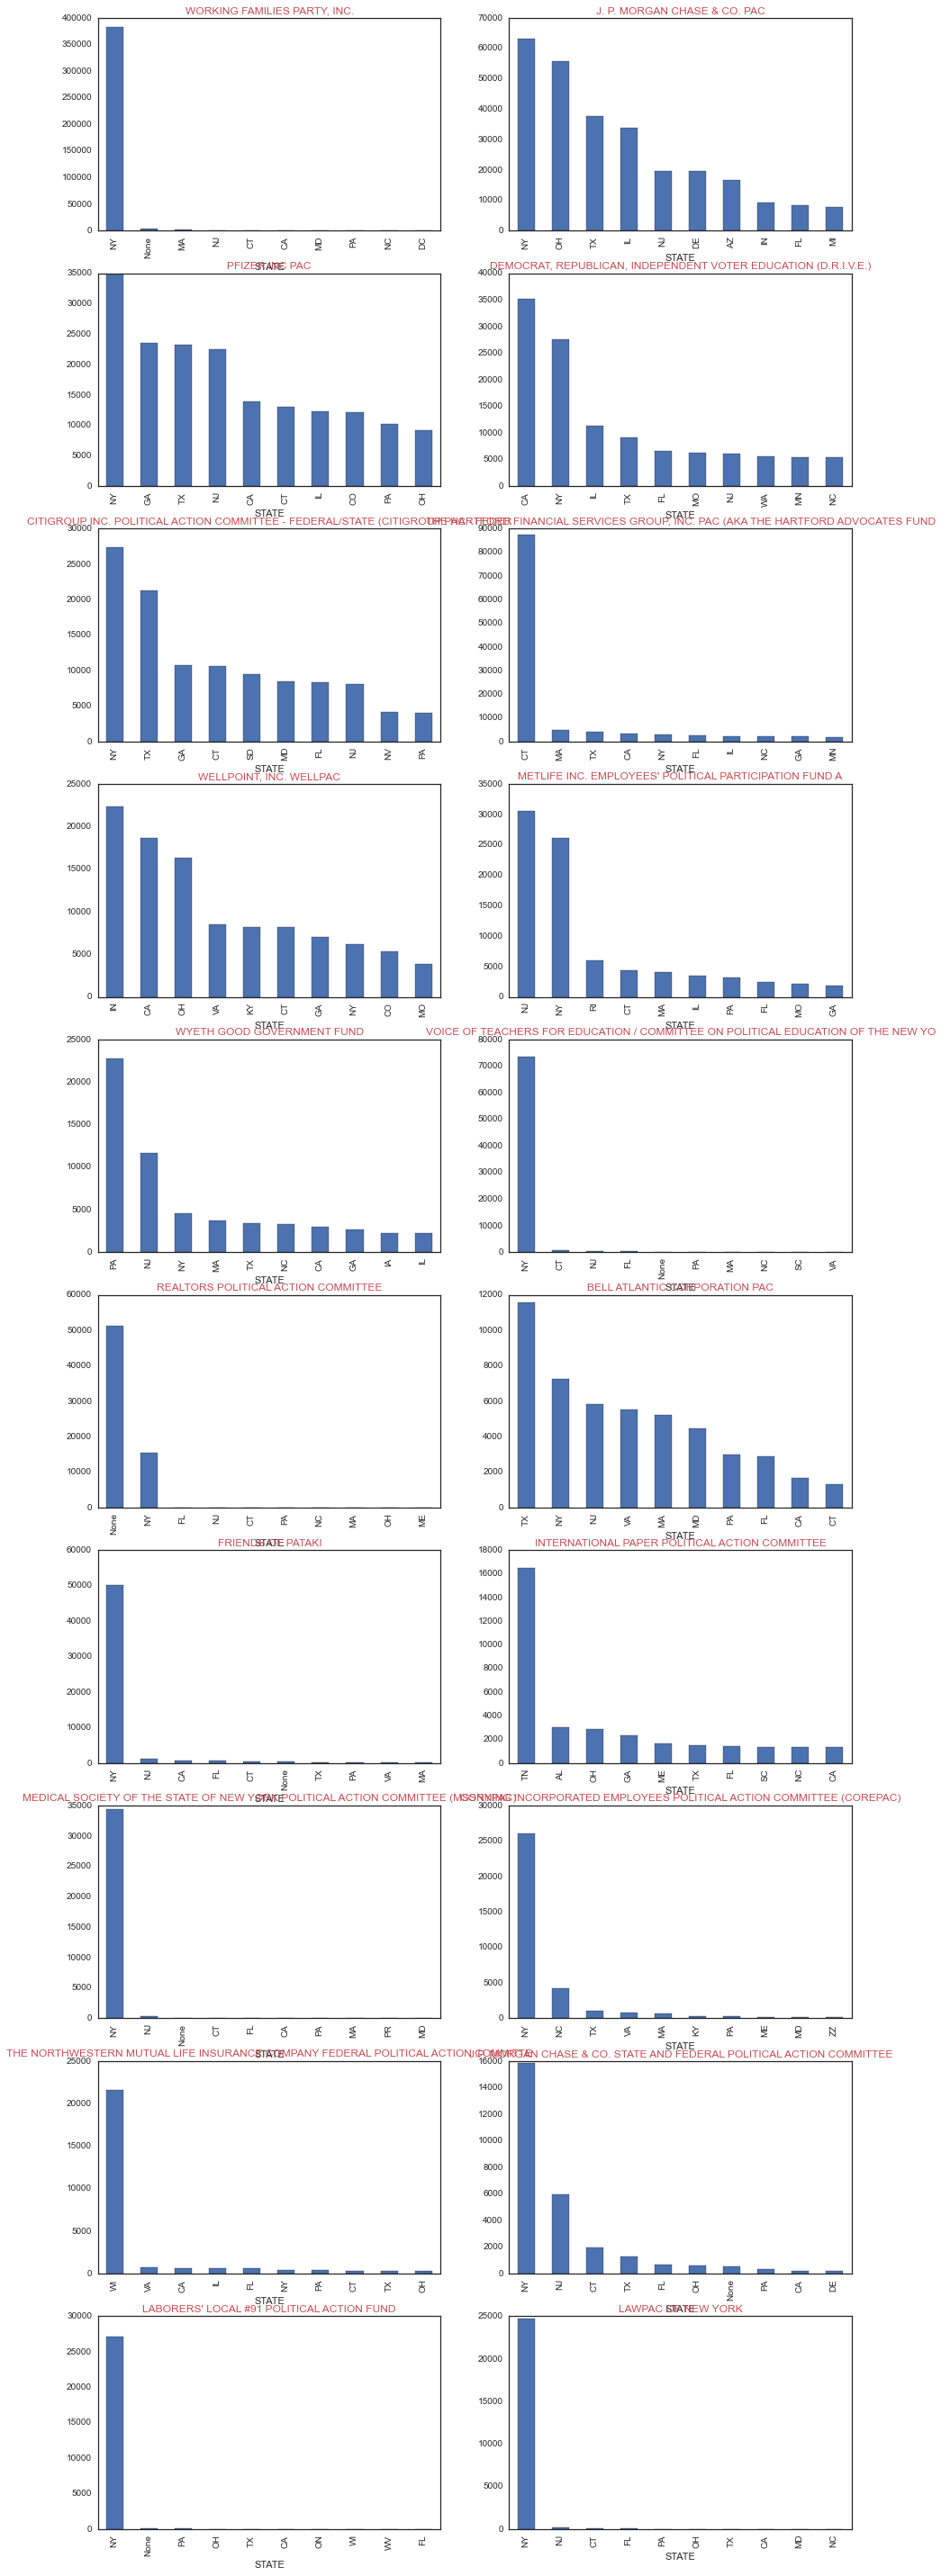

In [121]:
# Distribution by STATES
fig = plt.figure(figsize=(15,50))
for i in range(len(recipients)):
    data = individual.loc[individual['RECIPIENT'] == recipients[i],]
    plt.subplot(10,2,i+1)
    freqPlot = data.groupby(['STATE']).size().order(ascending=False)[:10].plot(kind='bar')
    plt.title(recipients[i], color='r')

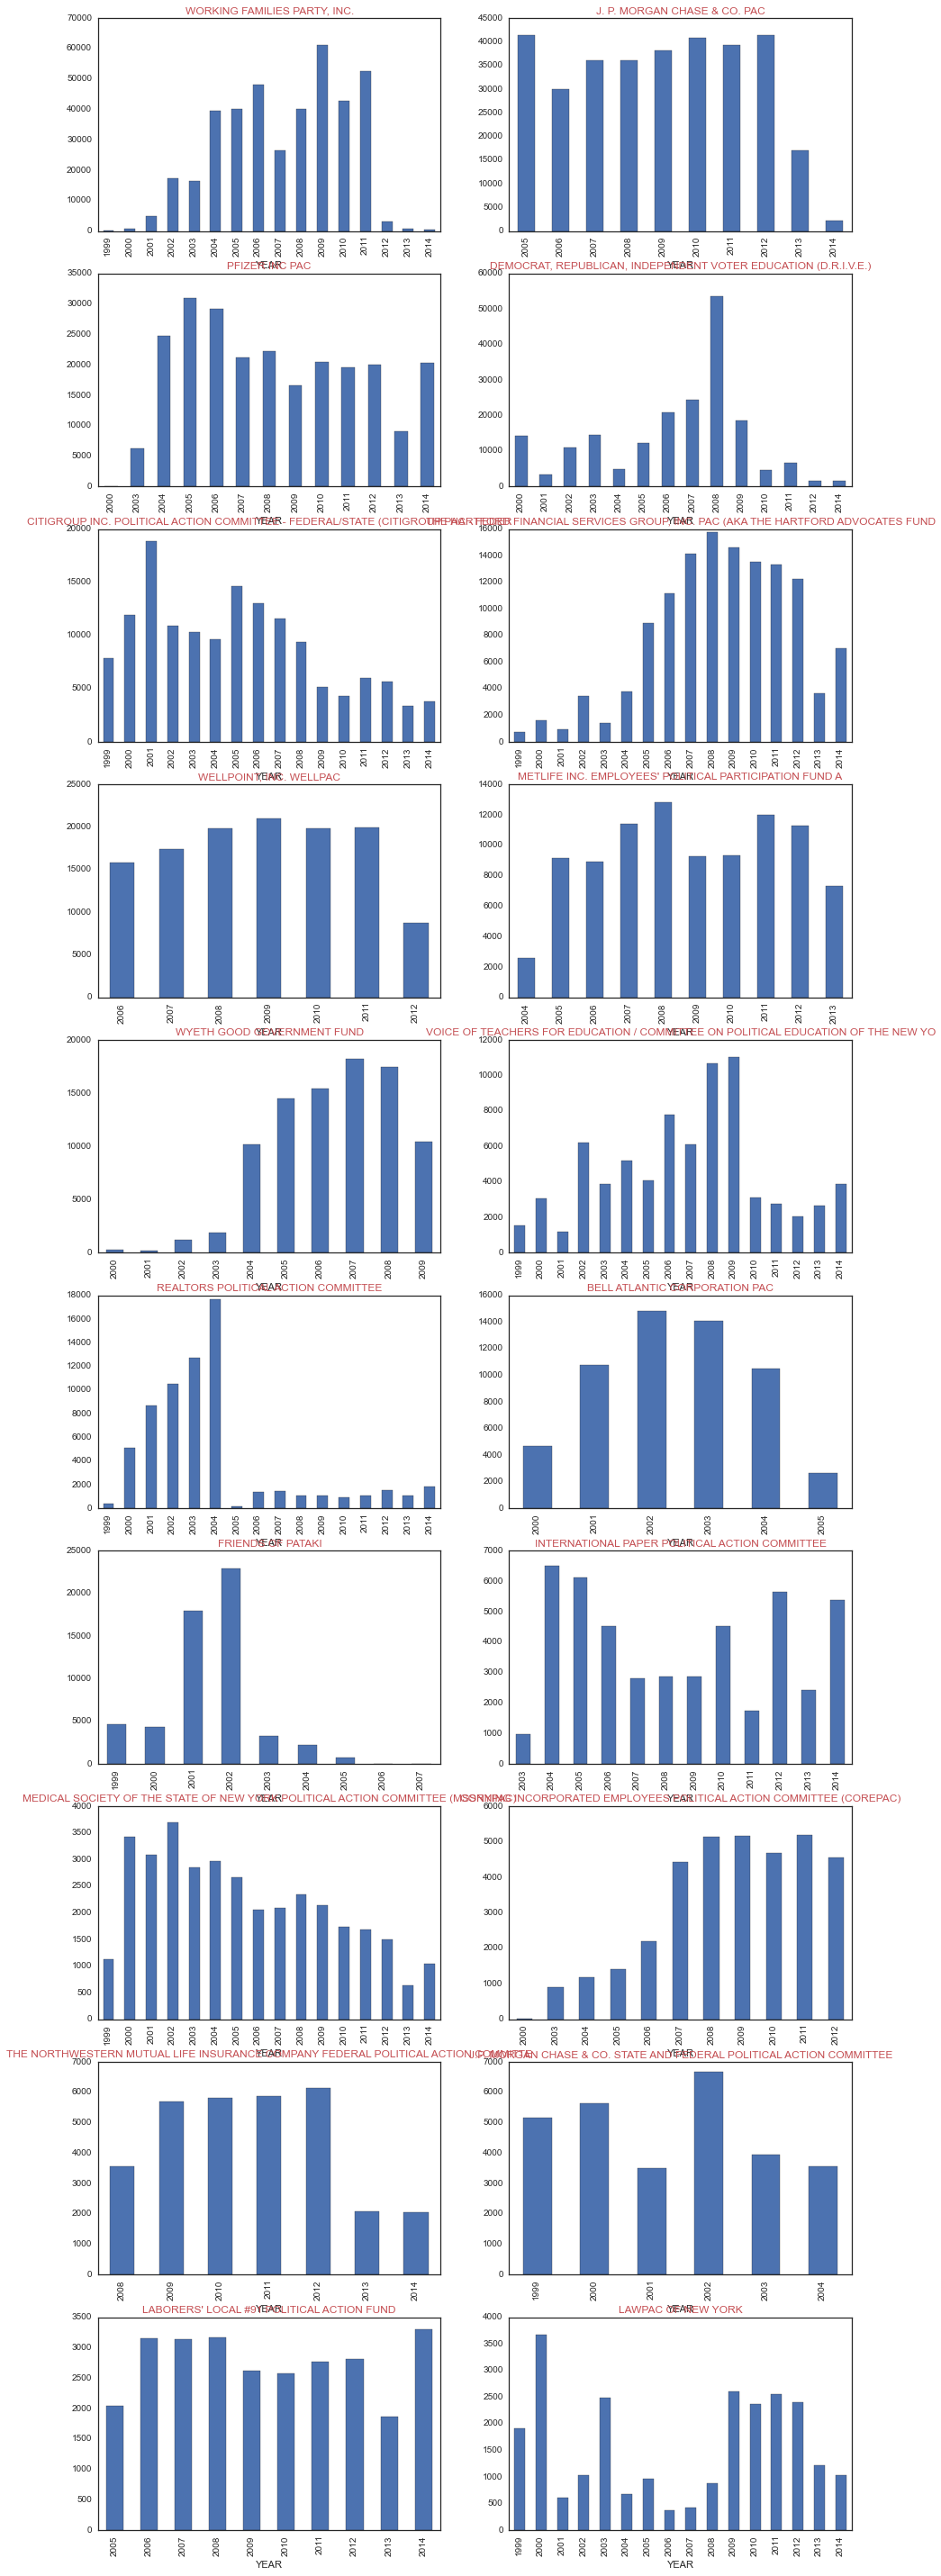

In [120]:
# Distribution by YEARS
fig = plt.figure(figsize=(15,50))
for i in range(len(recipients)):
    data = individual.loc[individual['RECIPIENT'] == recipients[i],]
    plt.subplot(10,2,i+1)
    freqPlot = data.groupby(['YEAR']).size().sort_index(ascending=True).plot(kind='bar')
    plt.title(recipients[i], color='r')

In [125]:
# Dropping rows with None value in AMOUNT
individual = individual.loc[individual['AMOUNT'] != 'None',]
individual.shape

(4858579, 15)

In [126]:
# Converting amount from string to float
import re
AMOUNT = list(individual['AMOUNT'])
print len(AMOUNT)
AMT = []
for i in range(len(AMOUNT)):
    AMT.append(int(float(re.sub(r'[?|$|!|,]',r'', AMOUNT[i]))))

print len(AMT)
individual.loc[:,'AMT'] = AMT

4858579
4858579


In [127]:
individual.head()

,Unnamed: 0,CORP,FIRST_NAME,LAST_NAME,ADDR,CITY,STATE,ZIP,RECIPIENT,FILER_ID,CHECK_NO,DATE1,AMOUNT,BOEE_ID,YEAR,AMT
0,0,None,JEFFRET,PETTIT,1088 PARK AVENUE,NEW YORK,NY,10028,500 CLUB,A00076,10163,2011-01-14 12:01:00,$500.00,1167,2011,500
1,1,None,JOHN,COFFIN,140 BROADWAY,NEW YORK,NY,10005,500 CLUB,A00076,4925,2011-01-14 12:01:00,$500.00,1168,2011,500
2,2,None,IAN,MACEACHRON,"103 EAST 84TH STREET, #8B",NEW YORK,NY,10028,500 CLUB,A00076,3182,2011-01-14 12:01:00,$500.00,1169,2011,500
3,3,None,JONATHAN,CONRAD,1088 PARK AVE.,NY,NY,10128,500 CLUB,A00076,5968,2011-01-14 12:01:00,$500.00,1170,2011,500
4,4,None,DONNA,SIMON,1725 YORK AVE.,NEW YORK,NY,10128,500 CLUB,A00076,992,2011-01-14 12:01:00,$500.00,1171,2011,500


RECIPIENT
BLOOMBERG FOR MAYOR 2009 INC.                                                       109234212
ANDREW CUOMO 2014, INC.                                                              41582560
FRIENDS OF PATAKI                                                                    28377757
SPITZER PATERSON 2006                                                                26020292
ANDREW CUOMO FOR ATTORNEY GENERAL, INC.                                              17648715
NYS SENATE REPUBLICAN CAMPAIGN COMMITTEE                                             14753018
PFIZER INC PAC                                                                       11981752
AMERICAN RESORT DEVELOPMENT ASSOCIATION RESORT OWNERS' COALITION PAC                 10502289
SPITZER 2013                                                                         10457423
QUINN FOR NEW YORK                                                                   10396816
FRIENDS OF  MCCALL/MEHIEL                         

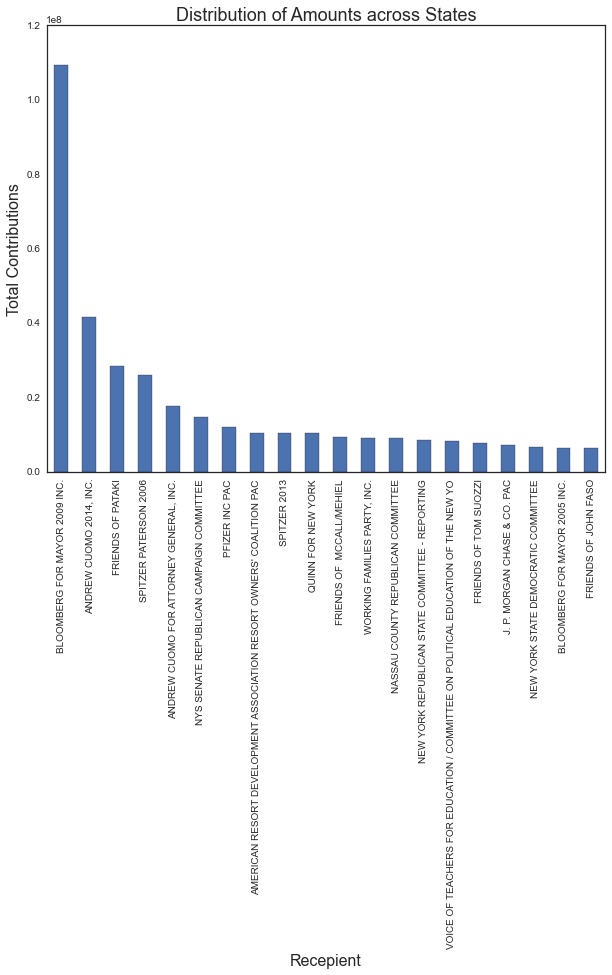

In [138]:
# Distributions of Amounts by Recipients
print individual.groupby(['RECIPIENT']).AMT.sum().order(ascending=False)[:20]
plt.figure(figsize=(10,8))
freqPlot = individual.groupby(['RECIPIENT']).AMT.sum().order(ascending=False)[:20].plot(kind='bar')
freqPlot.set_title("Distribution of Amounts across States", fontsize=18)
freqPlot.set_xlabel("Recepient", fontsize=16)
freqPlot.set_ylabel("Total Contributions", fontsize=16)

In [143]:
print len(individual['RECIPIENT'].unique())

11642


RECIPIENT
AMERICAN RESORT DEVELOPMENT ASSOCIATION RESORT OWNERS' COALITION PAC       24
ANDREW CUOMO 2014, INC.                                                 13128
ANDREW CUOMO FOR ATTORNEY GENERAL, INC.                                 14175
ANTHONY WEINER FOR MAYOR                                                 4886
ASTORINO FOR GOVERNOR                                                    6656
BELL ATLANTIC CORPORATION PAC                                           57496
BILL THOMPSON FOR MAYOR                                                  6331
BLOOMBERG FOR MAYOR 2005 INC.                                              13
BLOOMBERG FOR MAYOR 2009 INC.                                             108
CARRION NYC                                                              1754
dtype: int64
RECIPIENT
AMERICAN RESORT DEVELOPMENT ASSOCIATION RESORT OWNERS' COALITION PAC     10502289
ANDREW CUOMO 2014, INC.                                                  41582560
ANDREW CUOMO FOR ATTORN

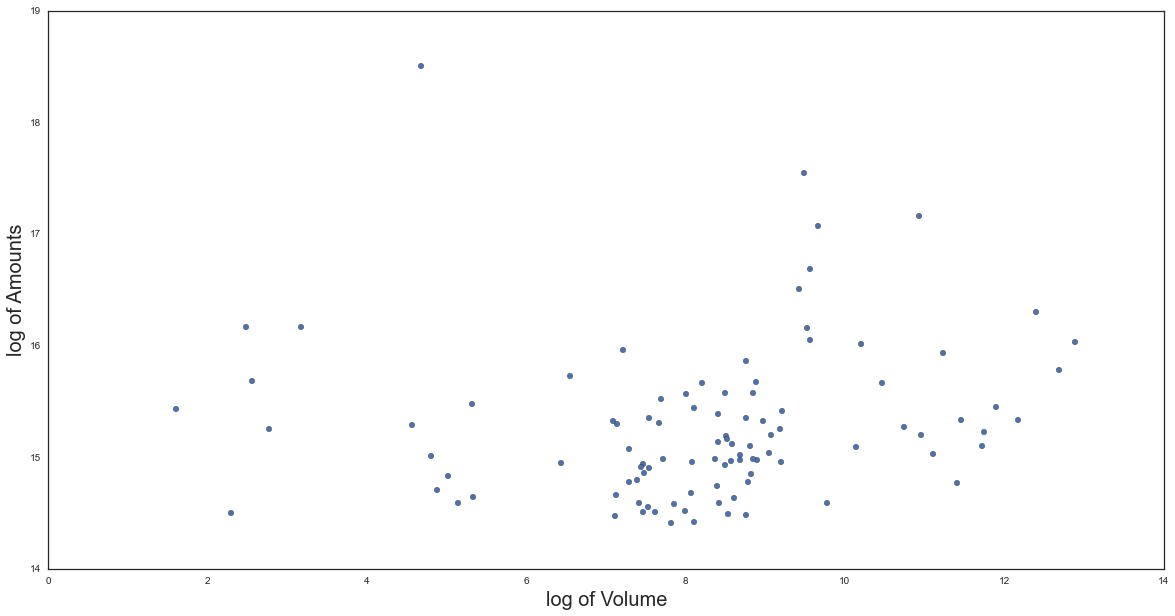

In [161]:
# Grouping by recipients
recipient_grouped = individual.groupby('RECIPIENT')
recipient_amounts = recipient_grouped['AMT'].aggregate(np.sum).order(ascending=False)[:100]
top100 = recipient_amounts.index
individual_top100 = individual.loc[(individual.RECIPIENT.isin(top100)),]
recipient_top100_grouped = individual_top100.groupby('RECIPIENT')
top100_recipient_counts = recipient_top100_grouped.size()
print top100_recipient_counts[:10]
top100_recipient_amounts = recipient_top100_grouped['AMT'].aggregate(np.sum)
print top100_recipient_amounts[:10]
plt.figure(figsize=(20,10))
plt.scatter(np.log(top100_recipient_counts), np.log(top100_recipient_amounts), s=30)
plt.xlabel("log of Volume", fontsize=20)
plt.ylabel("log of Amounts", fontsize=20)

In [162]:
individual.loc[individual['RECIPIENT'] == 'BLOOMBERG FOR MAYOR 2009 INC.',]

,Unnamed: 0,CORP,FIRST_NAME,LAST_NAME,ADDR,CITY,STATE,ZIP,RECIPIENT,FILER_ID,CHECK_NO,DATE1,AMOUNT,BOEE_ID,YEAR,AMT
3434902,4383912,None,MICHAEL,BLOOMBERG,17 EAST 79TH STREET,NEW YORK,NY,10075,BLOOMBERG FOR MAYOR 2009 INC.,C43295,None,2009-08-06 12:08:00,"$1,500,000.00",6780595,2009,1500000
3434903,4383913,None,MICHAEL,BLOOMBERG,17 EAST 79TH STREET,NEW YORK,NY,10075,BLOOMBERG FOR MAYOR 2009 INC.,C43295,None,2009-08-11 12:08:00,"$1,000,000.00",6780596,2009,1000000
3434904,4383914,None,MICHAEL,BLOOMBERG,17 EAST 79TH STREET,NEW YORK,NY,10075,BLOOMBERG FOR MAYOR 2009 INC.,C43295,None,2009-08-14 12:08:00,"$1,500,000.00",6780598,2009,1500000
3434905,4383915,None,MICHAEL,BLOOMBERG,17 EAST 79TH STREET,NEW YORK,NY,10075,BLOOMBERG FOR MAYOR 2009 INC.,C43295,None,2009-08-17 12:08:00,"$1,000,000.00",6780599,2009,1000000
3434906,4383916,None,MICHAEL,BLOOMBERG,17 EAST 79TH STREET,NEW YORK,NY,10075,BLOOMBERG FOR MAYOR 2009 INC.,C43295,None,2009-08-21 12:08:00,"$1,000,000.00",6780600,2009,1000000
3434907,4383917,None,MICHAEL,BLOOMBERG,17 EAST 79TH STREET,NEW YORK,NY,10075,BLOOMBERG FOR MAYOR 2009 INC.,C43295,None,2009-08-24 12:08:00,"$1,000,000.00",6780601,2009,1000000
3434908,4383918,None,MICHAEL,BLOOMBERG,17 EAST 79TH STREET,NEW YORK,NY,10075,BLOOMBERG FOR MAYOR 2009 INC.,C43295,None,2009-08-31 12:08:00,"$1,000,000.00",6780603,2009,1000000
3434909,4383919,None,MICHAEL,BLOOMBERG,17 EAST 79TH STREET,NEW YORK,NY,10075,BLOOMBERG FOR MAYOR 2009 INC.,C43295,None,2009-09-09 12:09:00,"$500,000.00",6780604,2009,500000
3434910,4383920,None,MICHAEL,BLOOMBERG,17 EAST 79TH STREET,NEW YORK,NY,10075,BLOOMBERG FOR MAYOR 2009 INC.,C43295,None,2009-09-10 12:09:00,"$1,900,000.00",6780605,2009,1900000
3434911,4383921,None,MICHAEL,BLOOMBERG,17 EAST 79TH STREET,NEW YORK,NY,10075,BLOOMBERG FOR MAYOR 2009 INC.,C43295,None,2009-09-14 12:09:00,"$250,000.00",6780606,2009,250000


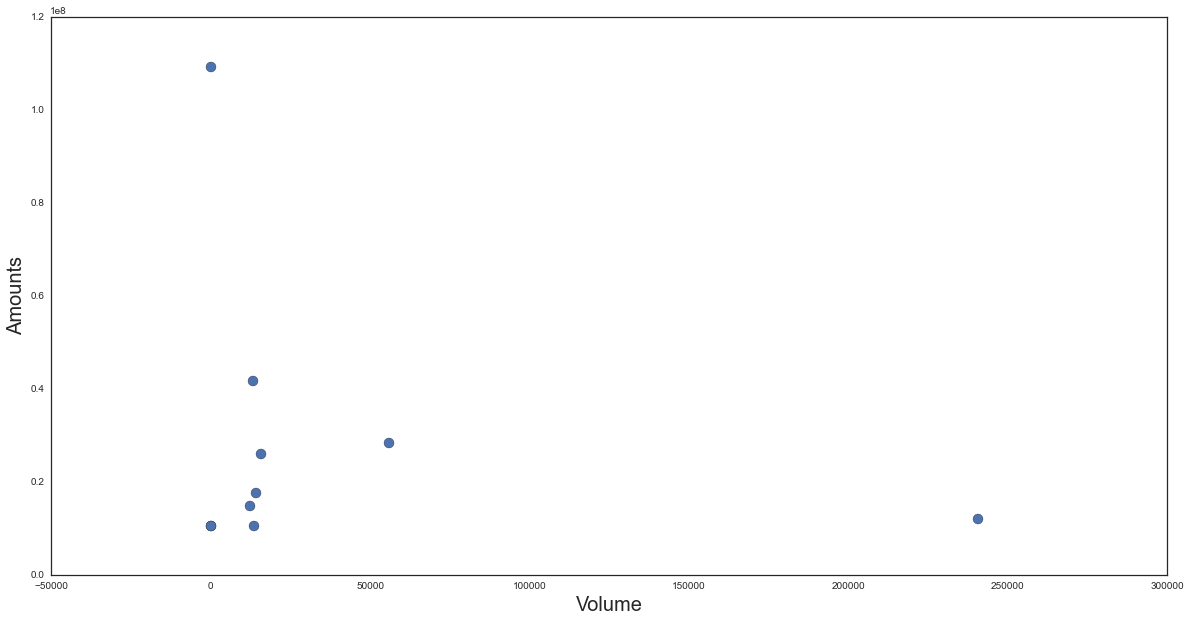

In [159]:
# Grouping by recipients only for top 10
recipient_grouped = individual.groupby('RECIPIENT')
recipient_amounts = recipient_grouped['AMT'].aggregate(np.sum).order(ascending=False)[:10]
top10 = recipient_amounts.index
individual_top10 = individual.loc[(individual.RECIPIENT.isin(top10)),]
recipient_top10_grouped = individual_top10.groupby('RECIPIENT')
top10_recipient_counts = recipient_top10_grouped.size()
top10_recipient_amounts = recipient_top10_grouped['AMT'].aggregate(np.sum)
plt.figure(figsize=(20,10))
plt.scatter(top10_recipient_counts, top10_recipient_amounts, s=100)
plt.xlabel("Volume", fontsize=20)
plt.ylabel("Amounts", fontsize=20)

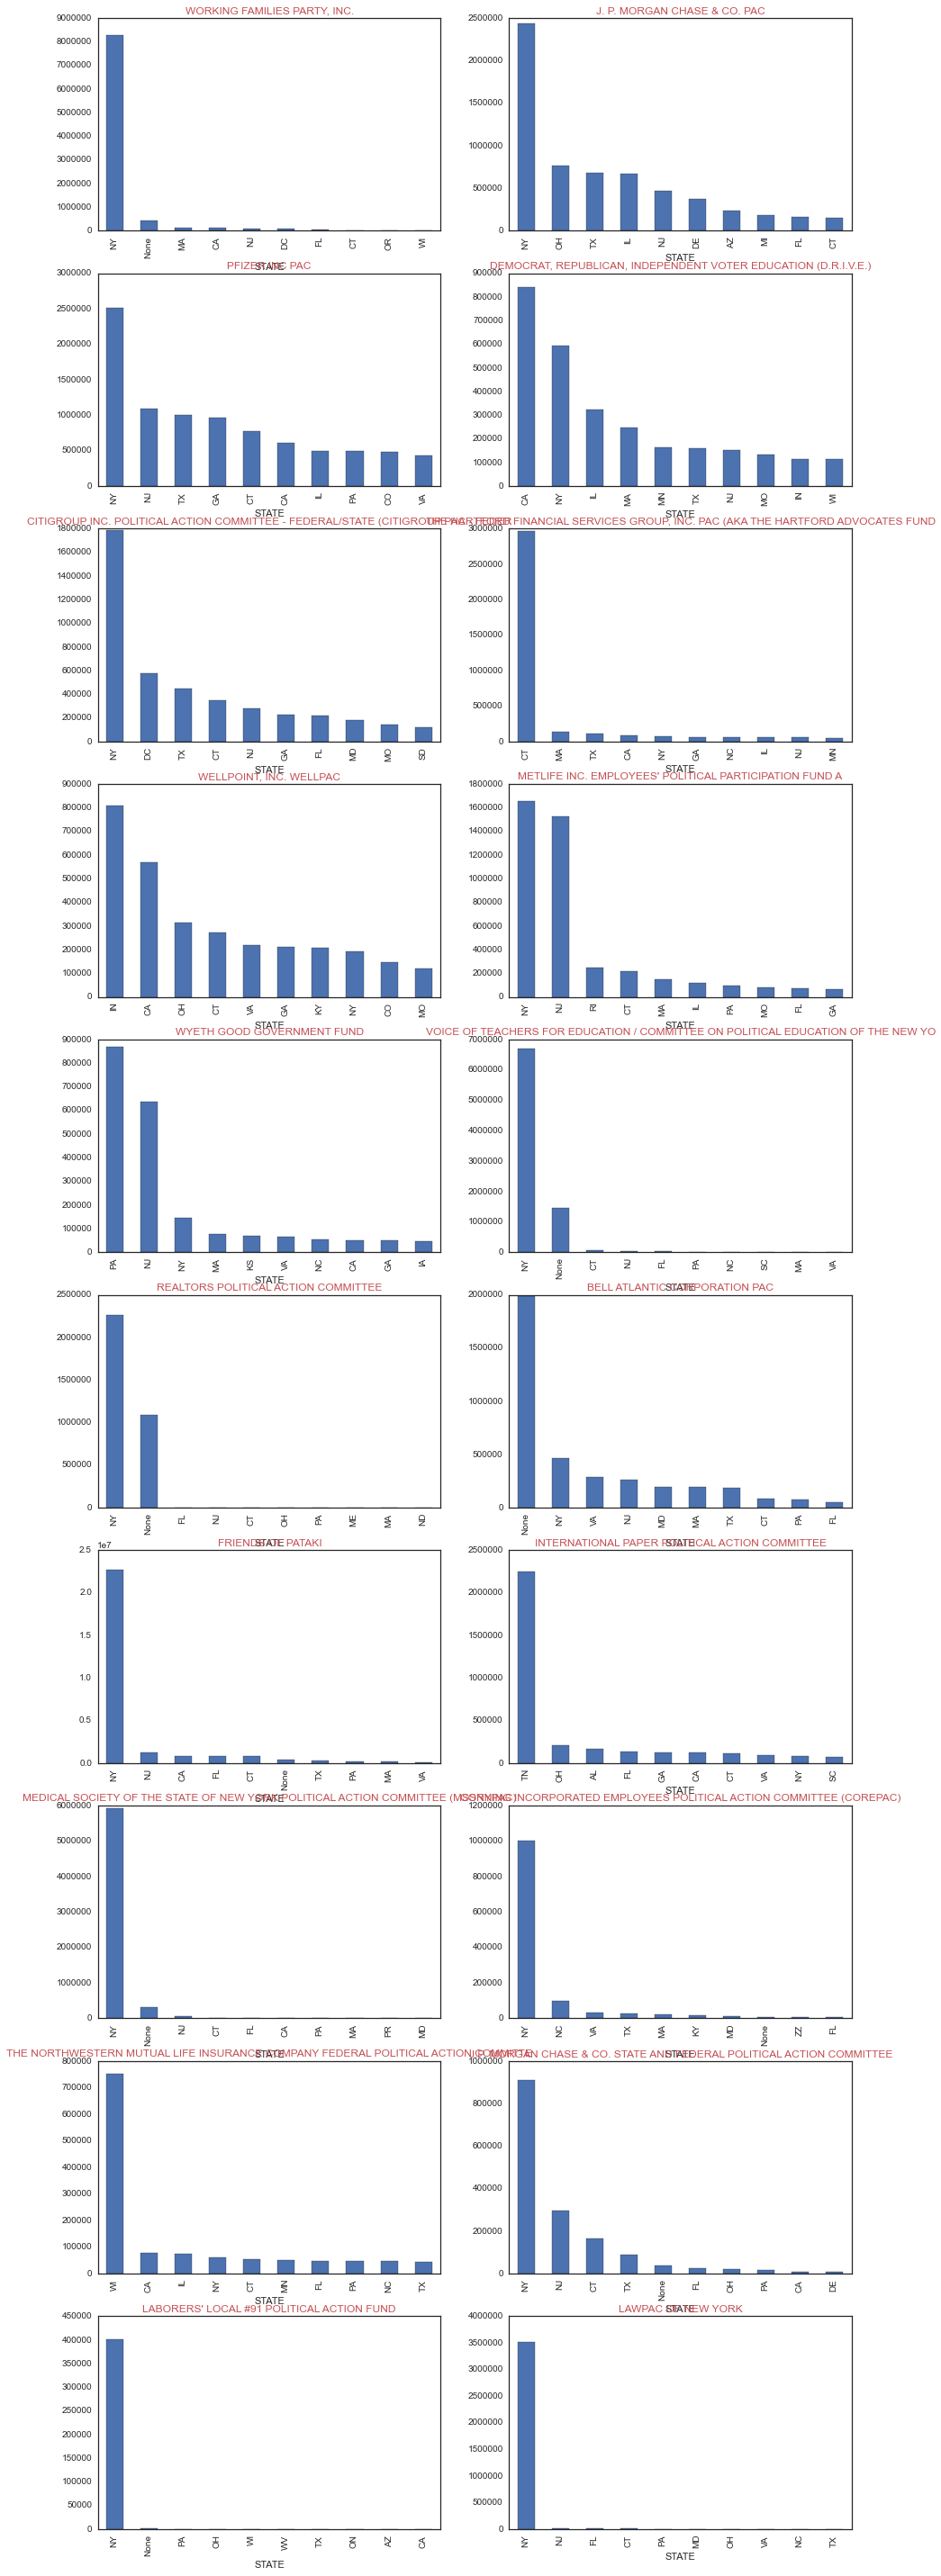

In [137]:
# Sum of Amounts by States for top 20 volume recipients
fig = plt.figure(figsize=(15,50))
for i in range(len(recipients)):
    data = individual.loc[individual['RECIPIENT'] == recipients[i],]
    plt.subplot(10,2,i+1)
    freqPlot = data.groupby(['STATE']).AMT.sum().order(ascending=False)[:10].plot(kind='bar')
    plt.title(recipients[i], color='r')

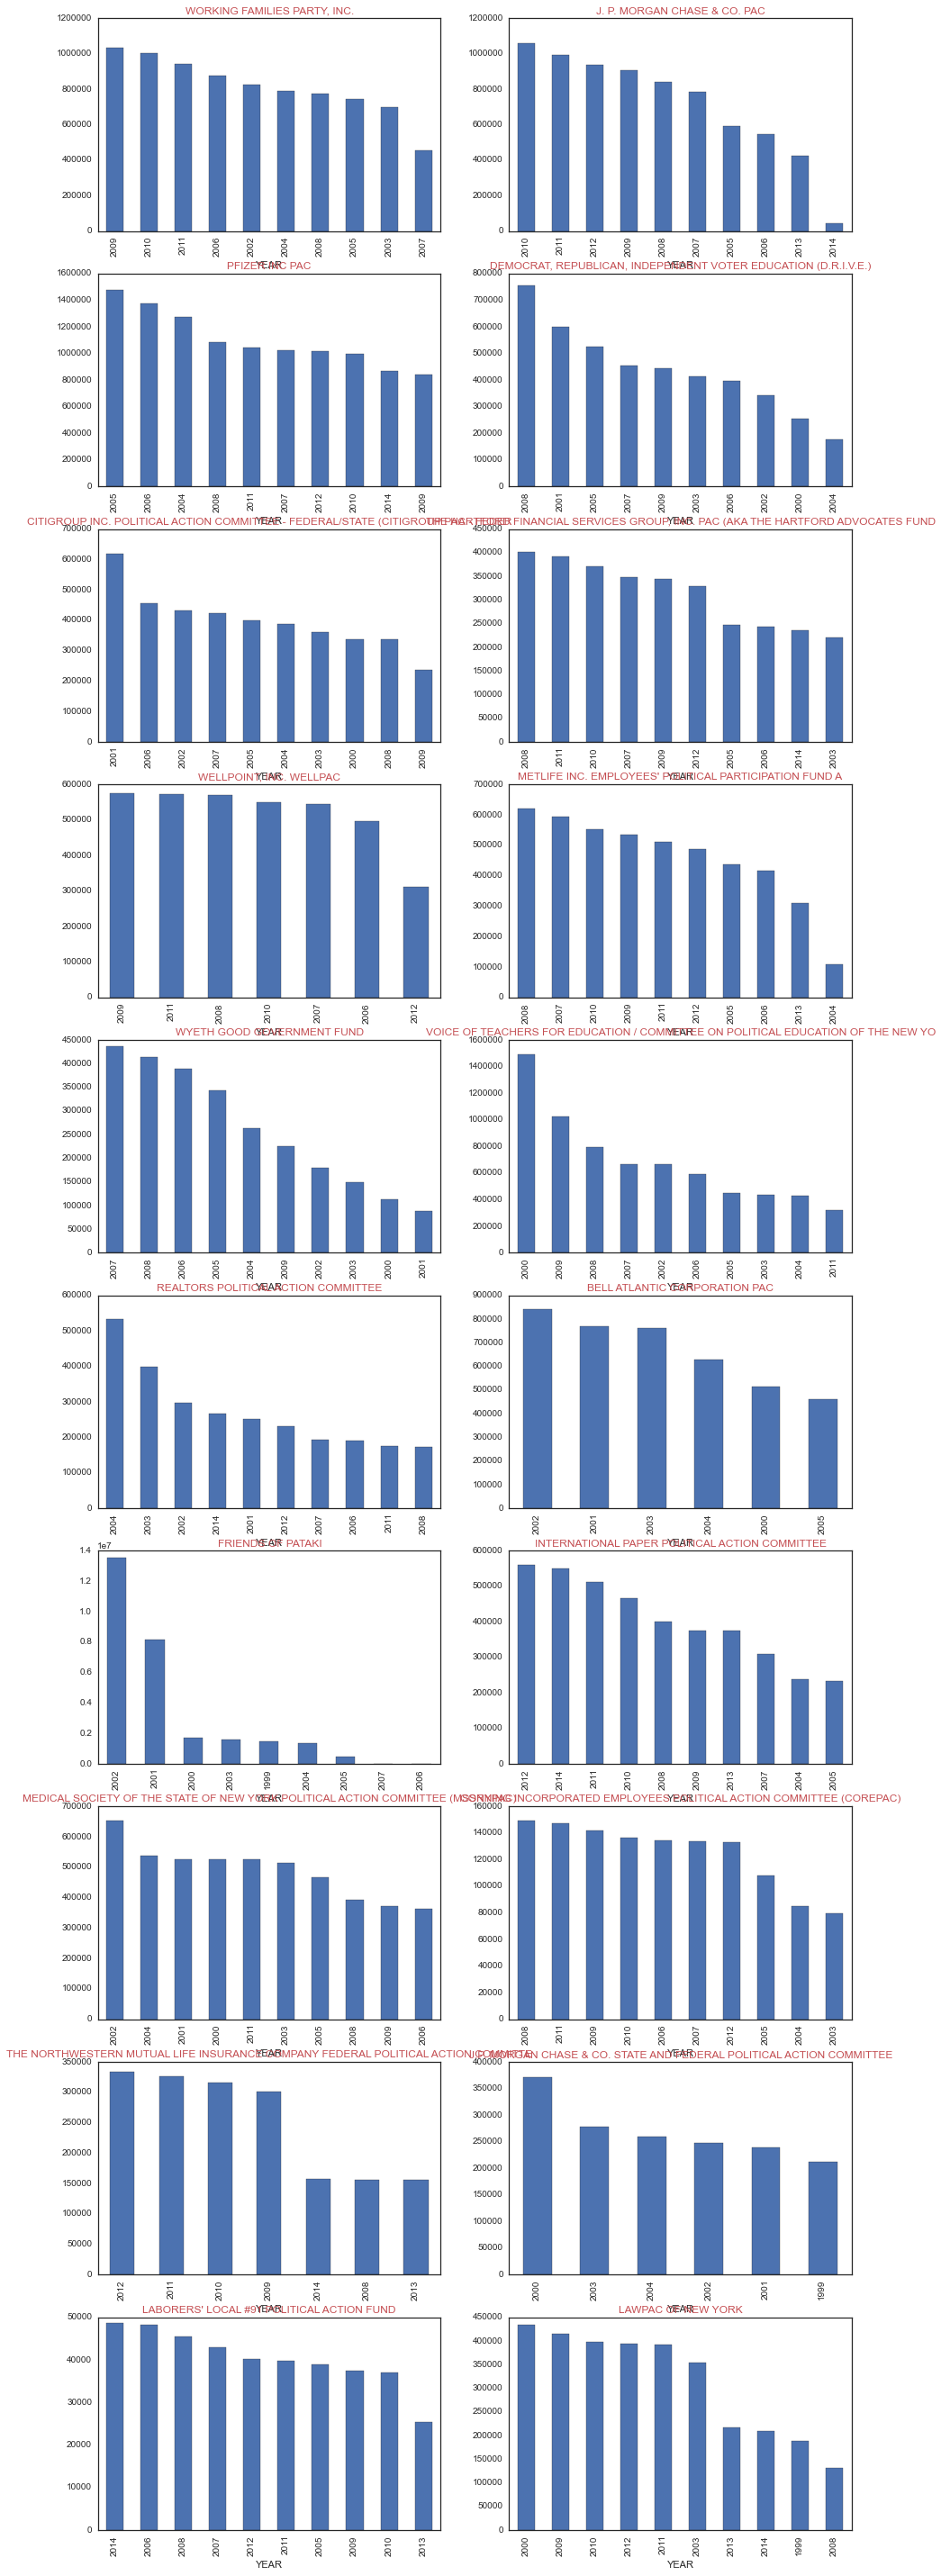

In [139]:
# Sum of Amounts by Years for top 20 volume recipients 
fig = plt.figure(figsize=(15,50))
for i in range(len(recipients)):
    data = individual.loc[individual['RECIPIENT'] == recipients[i],]
    plt.subplot(10,2,i+1)
    freqPlot = data.groupby(['YEAR']).AMT.sum().order(ascending=False)[:10].plot(kind='bar')
    plt.title(recipients[i], color='r')